In [1]:
# First attach your google drive to the colab
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
#GPU type & space
!nvidia-smi -L
!nvidia-smi

GPU 0: Tesla T4 (UUID: GPU-7d590e37-c375-0f4a-5c13-64c3536b8020)
Mon Mar  6 12:46:15 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P0    28W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                       

In [3]:
import os
os.chdir('/content/drive/MyDrive/sample')
root = os.getcwd()
print("The Current working directory is :", root)

The Current working directory is : /content/drive/MyDrive/sample


In [4]:
# Import required libraries
import os
import numpy as np
import pandas as pd
import random
from PIL import Image
import torch.utils.data as data
from torchvision.models.resnet import resnet34
import torchvision.transforms as transforms
import torch
import torch
import torch.nn as nn
import torch.optim as optim

from torch.optim.lr_scheduler import *
import torchvision.transforms as transforms

from torchvision import transforms, datasets
from torch.utils.data import  SubsetRandomSampler
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold

import torch.nn.functional as F

In [5]:
PIL_transform=transforms.RandomApply([transforms.RandomHorizontalFlip(p=1),transforms.RandomVerticalFlip(p=1),
                                      transforms.RandomRotation(45)],p=0.5)

transform_train = transforms.Compose([
    transforms.Resize((256, 256)),  # 256x256
    PIL_transform,
    transforms.RandomCrop((225, 225)),  # 224x224
    #transforms.RandomHorizontalFlip(),  # 
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.2225))  # ImageNet
])
 
# 
transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])
 

cell_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/sample',transform=transform_train)

#define dataloader
dataset_loader = DataLoader(cell_dataset,batch_size=16, shuffle=True,num_workers=4)

split1 = int(0.2 * len(cell_dataset))
split2 = int(0.8 * len(cell_dataset))
index_list = list(range(len(cell_dataset)))
np.random.shuffle(index_list) 
test_idx = index_list[:split1]+index_list[split2:]
train_idx=index_list[split1:split2]

## create training and validation sampler objects
tr_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(test_idx)
#trainset=cell_dataset[split1:split2]

## create iterator objects for train and valid datasets
trainloader = DataLoader(cell_dataset, batch_size=16,sampler=tr_sampler,num_workers=4)
validloader = DataLoader(cell_dataset, batch_size=16,sampler=val_sampler,num_workers=4)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [6]:
len(cell_dataset)

2961

In [7]:
def get_acc(output, label):
    total = output.shape[0]
    _, pred_label = output.max(1)
    num_correct = (pred_label == label).sum().item()
    return num_correct / total

def train_epoch(model,device,dataloader,loss_fn,optimizer):
    train_loss,train_correct=0.0,0
    model.train()
    for images, labels in dataloader:

        images,labels = images.to(device),labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = loss_fn(output,labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        scores, predictions = torch.max(output.data, 1)
        train_correct += (predictions == labels).sum().item()

        train_acc = get_acc(output, labels)
        print("loss:%f acc:%f" % (loss.mean(), train_acc))   

    return train_loss,train_correct
  
def valid_epoch_2(model,device,dataloader,loss_fn):
    valid_loss, val_correct = 0.0, 0
    model.eval()
    y_val=[]
    y_pred=[]
    for images, labels in dataloader:

        images,labels = images.to(device),labels.to(device)

        y_val.append(F.one_hot(labels, num_classes=4))
        
        output = model(images)
        loss=loss_fn(output,labels)
        valid_loss+=loss.item()*images.size(0)
        scores, predictions = torch.max(output.data,1)

        y_pred.append(F.one_hot(predictions, num_classes=4))

        val_correct+=(predictions == labels).sum().item()

    return valid_loss,val_correct,y_val,y_pred

class Net(nn.Module):
    def __init__(self, model):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, stride=2, padding=2,bias=False)
        self.resnet_layer = nn.Sequential(*list(model.children())[1:-1])
        self.Linear_layer = nn.Linear(512, 8) 
 
    def forward(self, x):
        x = self.conv1(x)
        x = self.resnet_layer(x)
        x = x.view(x.size(0), -1)
        x = self.Linear_layer(x)
        return x    

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [9]:
if __name__ == '__main__':

  # Model Configuration
  resnet = resnet34(pretrained=True)
  model = Net(resnet)
  model = model.to(device)
  optimizer = optim.Adam(model.parameters(),lr=1e-4,betas=(0.9,0.999),eps=1e-8,weight_decay=5e-4,amsgrad=True)
  
  # Configuration options
  k_folds = 3
  num_epochs = 1
  batch_size = 16
  
  # For fold results
  history = {'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc':[]}
  
  # Set fixed random number seed
  torch.manual_seed(42)

  criterion = nn.CrossEntropyLoss()

  # Define the K-fold Cross Validator
  kfold = KFold(n_splits=k_folds, shuffle=True)

  y_test_folds=[]
  y_pred_folds=[]

  # Start print
  print('--------------------------------')

  # K-fold Cross Validation model evaluation
  for fold, (train_idx, test_idx) in enumerate(kfold.split(cell_dataset)):
    
    # Print
    print(f'FOLD {fold+1}')
    print('--------------------------------')
    
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    train_loader = DataLoader(cell_dataset, batch_size=batch_size, sampler=train_sampler)
    test_loader = DataLoader(cell_dataset, batch_size=batch_size, sampler=test_sampler)
    
    # Run the training loop for defined number of epochs
    for epoch in range(0, num_epochs):

      # Print epoch
      print(f'Starting epoch {epoch+1}')
        
      train_loss, train_correct=train_epoch(model,device,train_loader,criterion,optimizer)
      test_loss, test_correct, test_labels, test_preds=valid_epoch_2(model,device,test_loader,criterion)


      train_loss = train_loss / len(train_loader.sampler)
      train_acc = train_correct / len(train_loader.sampler) * 100
      test_loss = test_loss / len(test_loader.sampler)
      test_acc = test_correct / len(test_loader.sampler) * 100

      print("Epoch:{}/{} AVG Training Loss:{:.3f} AVG Test Loss:{:.3f} AVG Training Acc {:.2f} % AVG Test Acc {:.2f} %".format(epoch + 1,
                                                                                                             num_epochs,
                                                                                                             train_loss,
                                                                                                             test_loss,
                                                                                                             train_acc,
                                                                                                             test_acc))
      
      history['train_loss'].append(train_loss)
      history['test_loss'].append(test_loss)
      history['train_acc'].append(train_acc)
      history['test_acc'].append(test_acc)

    y_test_folds.append(test_labels) 
    y_pred_folds.append(test_preds) 

    # Write models on disk
    foldNum = str(fold+1)
    model_name = 'model'+foldNum+'.pth'
    torch.save(model, model_name)


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

--------------------------------
FOLD 1
--------------------------------
Starting epoch 1
loss:2.479455 acc:0.250000
loss:2.216729 acc:0.187500
loss:1.871572 acc:0.250000
loss:1.850752 acc:0.187500
loss:1.921334 acc:0.125000
loss:1.750744 acc:0.312500
loss:1.519161 acc:0.437500
loss:1.496542 acc:0.437500
loss:1.558100 acc:0.437500
loss:1.594742 acc:0.437500
loss:1.465745 acc:0.437500
loss:1.210662 acc:0.562500
loss:1.486891 acc:0.500000
loss:1.093872 acc:0.625000
loss:0.854638 acc:0.812500
loss:1.024534 acc:0.562500
loss:0.907783 acc:0.687500
loss:1.210218 acc:0.625000
loss:0.968805 acc:0.687500
loss:0.993959 acc:0.812500
loss:0.638864 acc:0.687500
loss:0.903354 acc:0.625000
loss:1.594026 acc:0.500000
loss:0.914008 acc:0.687500
loss:0.731737 acc:0.812500
loss:1.025416 acc:0.562500
loss:0.770066 acc:0.875000
loss:0.619284 acc:0.875000
loss:0.715021 acc:0.625000
loss:1.007445 acc:0.500000
loss:1.003445 acc:0.562500
loss:0.732796 acc:0.812500
loss:0.587835 acc:0.750000
loss:1.002314 acc:0

In [10]:
history['test_acc']

[89.96960486322189, 94.12360688956434, 96.55521783181358]

In [11]:
# required libraries for AUC plot
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
from itertools import cycle

## Get labels and prediction

In [12]:
y_test_arr=[]
y_test_flt=[]
for i in range(len(y_test_folds)):
    y_testTensor = torch.cat(y_test_folds[i])
    y_testTensor.numel()    
    test_stk_tensor = y_testTensor.cpu().numpy()
    y_test_arr.append(test_stk_tensor)
    y_test_np = torch.flatten(y_testTensor).cpu().numpy()
    y_test_flt.append(y_test_np)

y_pred_arr=[]
y_pred_flt=[]
for j in range(len(y_pred_folds)):
    y_predTensor = torch.cat(y_pred_folds[j])
    y_predTensor.numel()
    pred_stk_tensor = y_predTensor.cpu().numpy()
    y_pred_arr.append(pred_stk_tensor) 
    y_pred_np = torch.flatten(y_predTensor).cpu().numpy()
    y_pred_flt.append(y_pred_np)   

In [20]:
y_test_flt_out = np.concatenate(y_test_flt).ravel()
y_pred_flt_out = np.concatenate(y_pred_flt).ravel()

In [14]:
y_test_arr=np.array(y_test_arr)
y_pred_arr=np.array(y_pred_arr)

In [21]:
y_test_final=np.resize(y_test_arr, (y_test_arr.shape[1], y_test_arr.shape[2]))
y_pred_final=np.resize(y_pred_arr, (y_pred_arr.shape[1], y_pred_arr.shape[2]))

In [22]:
y_test_final.shape
y_pred_final.shape

(987, 4)

In [23]:
classes=('CMS1', 'CMS2', 'CMS3', 'CMS4')
n_classes = len(classes)

## ROC curve using micro-averaged OvR

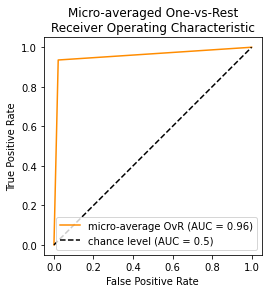

In [24]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(
    y_test_flt_out.ravel(),
    y_pred_flt_out.ravel(),
    name="micro-average OvR",
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Micro-averaged One-vs-Rest\nReceiver Operating Characteristic")
plt.legend()
plt.show()

In [25]:
from sklearn.metrics import roc_auc_score

micro_roc_auc_ovr = roc_auc_score(
    y_test_flt_out,
    y_pred_flt_out,
    multi_class="ovr",
    average="micro",
)

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{micro_roc_auc_ovr:.2f}")

Micro-averaged One-vs-Rest ROC AUC score:
0.96


## Another way to obtain the OvR micro-average

In [26]:
from sklearn.metrics import roc_curve, auc

# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_flt_out.ravel(), y_pred_flt_out.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")

Micro-averaged One-vs-Rest ROC AUC score:
0.96


## obtain the OvR macro-average

In [31]:
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_final[:,i], y_pred_final[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])


fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")

Macro-averaged One-vs-Rest ROC AUC score:
0.92


## Another way to obtain the OvR macro-average

In [32]:
macro_roc_auc_ovr = roc_auc_score(
    y_test_final,
    y_pred_final,
    multi_class="ovr",
    average="macro",
)

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{macro_roc_auc_ovr:.2f}")

Macro-averaged One-vs-Rest ROC AUC score:
0.92


## Plot all OvR ROC curves together

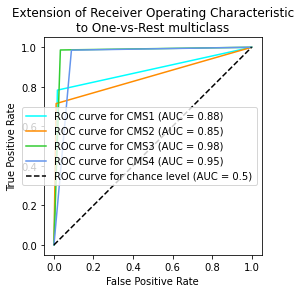

In [33]:
from itertools import cycle

fig, ax = plt.subplots(figsize=(4, 4))


colors = cycle(["aqua", "darkorange", "limegreen", "cornflowerblue"])
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_test_final[:, class_id],
        y_pred_final[:, class_id],
        name=f"ROC curve for {classes[class_id]}",
        color=color,
        ax=ax,
    )

plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass")
plt.legend()
plt.show()

## with mico and macro

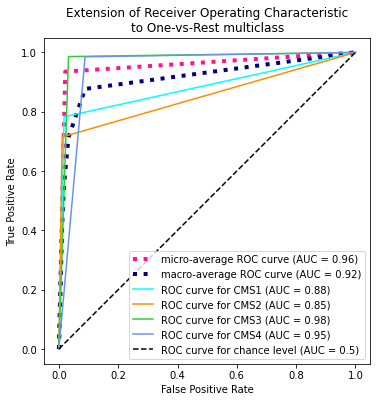

In [34]:
from itertools import cycle

fig, ax = plt.subplots(figsize=(6, 6))

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "limegreen", "cornflowerblue"])
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_test_final[:, class_id],
        y_pred_final[:, class_id],
        name=f"ROC curve for {classes[class_id]}",
        color=color,
        ax=ax,
    )

plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass")
plt.legend()
plt.show()

## Precision and Recall score for each class

In [35]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

print("Precision scores for 4 classes are:", precision_score(y_test_final, y_pred_final, average=None))
print("Recall scores for 4 classes are:", recall_score(y_test_final, y_pred_final, average=None))

Precision scores for 4 classes are: [0.91358025 0.93181818 0.89495798 0.88791209]
Recall scores for 4 classes are: [0.78306878 0.71511628 0.98611111 0.98536585]


## Text summary of the Precision, Recall, F1 score for each class

In [36]:
from sklearn.metrics import classification_report
class_names = ['CMS1', 'CMS2', 'CMS3', 'CMS4']
print(classification_report(y_test_final, y_pred_final, target_names=class_names))

              precision    recall  f1-score   support

        CMS1       0.91      0.78      0.84       189
        CMS2       0.93      0.72      0.81       172
        CMS3       0.89      0.99      0.94       216
        CMS4       0.89      0.99      0.93       410

   micro avg       0.90      0.90      0.90       987
   macro avg       0.91      0.87      0.88       987
weighted avg       0.90      0.90      0.90       987
 samples avg       0.90      0.90      0.90       987

